In [1]:
## yikes idk how you would do this anymore

# %load_ext autoreload
# %aimport ..CGProcessor

In [2]:
import sys 
 
sys.path.insert(0, '../')
from CGProcessor import CGProcessor
sys.path.pop(0)

'../'

In [3]:
from bin import Statistics, Tests, Transforms

In [4]:
# %autoreload 1

import pandas as pd
import numpy as np


from datetime import timezone
import pytz


In [5]:
# coin_list = cg.get_coins_list()

# ids = [coin_data['id'] for coin_data in coin_list]

# id_to_data = {}
# for coin_data in coin_list:
#     id_to_data[coin_data.pop('id')] = coin_data
# ids = id_to_data.keys()

In [6]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)

In [7]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']
start_date, end_date = (2020,1,1), (2021,10,31)

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [8]:
##################
## LOCAL DRIVER ##
##################

cgp = CGProcessor()

# Create portfolio dataframe
port_val = cgp.create_portfolio(PORT_IDS, start_date, end_date)
data = cgp.data

cgp.normalize([], port=True)

In [9]:
display(data)

,bitcoin,bitcoin-cash,ethereum,litecoin
1577836800000,7195.153895,204.561792,129.186385,41.330312
1577923200000,7193.754668,204.348311,130.484685,41.606316
1578009600000,6963.853354,195.674640,127.045258,39.413813
1578096000000,7300.346935,221.621452,133.702649,41.991047
1578182400000,7351.377053,224.487505,134.136883,42.781417
...,...,...,...,...
1635292800000,60604.188888,609.848740,4152.570289,198.406010
1635379200000,58641.001474,551.244177,3944.090862,180.241936
1635465600000,60767.555852,579.019616,4288.097219,190.168430
1635552000000,62283.198056,591.975602,4422.940536,196.704274


<Figure size 432x288 with 0 Axes>

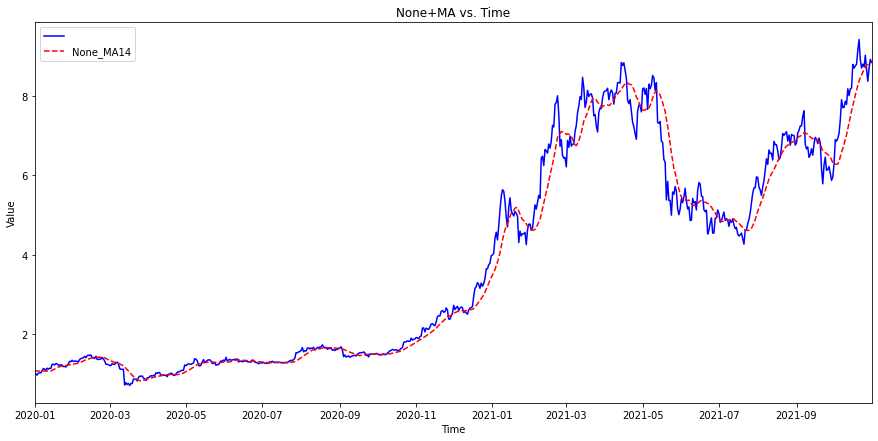

t-stat = -26.947774112209135: The series None_RM_I is stationary with confidence level  99%
(-26.967288470241495, 0.0, array([-3.91288546, -3.34527843, -3.05079569]))


In [10]:
############
## TEST 1 ##
############

# Create normalized timeseries for portfolio
port_rm = cgp.roll_avg(ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


# IF a random variable is stationary THEN it is also order one integratable #

port_ret = Transforms.integrate(port_rm)

comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
coint_res = Tests.is_coint(port_ret, comparator)
print(coint_res)

### Testing cointegration of crypto basket
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is non-stationary and order-1 integrable</li>
    <li>Using Multivariate Linear Regression, find coef_ for Linear Combination of {coins}</li>
    <li>Check that the linear regression RESIDUAL is stationary using Augmented Dickey-Fuller test</li>
</ol>

Then, {coins} is cointegrated

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>As of now, we have not found a regression that makes th residuals stationay (ie. not cointegrated)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

In [11]:
############
## TEST 2 ##
############

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

print("Verifying coin price stationarity...")
stationarity = []
for coin in data:
    coin_stationarity = Tests.test_stationarity(data[coin])
    coin_prime = Transforms.differentiate(data[coin])
    coin_prime_stationarity = Tests.test_stationarity(coin_prime)
    stationarity.append(not coin_stationarity & coin_prime_stationarity)
print(stationarity) # BITCOIN CASH IS NOT ORDER 1 INTEGRABLE

lm = LinearRegression(copy_X=True)
X = data.drop(['bitcoin'], axis=1)
y = data['bitcoin']

print("Normalizing...")
scaler = MinMaxScaler()
scaler.fit(X, y)
X_scaled = scaler.transform(X) # TODO: Finish normalization
X_scaled = pd.DataFrame(X_scaled/X_scaled[0], index=X.index) 
X_scaled.columns = X.columns

lm.fit(X_scaled, y)
coef = lm.coef_
constant = lm.intercept_
residuals = y - X.multiply(coef).sum(axis=1)
residuals.name = 'Residuals'
display(residuals)

is_stationary = Tests.test_stationarity(residuals, pct='1%')

# USING OLS INSTEAD

# X = sm.add_constant(X)
# est = sm.OLS(y, X).fit()
# display(est.summary())

# coef_ols = est.params.values
# residuals2 = y - X.multiply(coef_ols).sum(axis=1)
# is_stationary = Tests.test_stationarity(residuals, pct='1%')

Verifying coin price stationarity...
t-stat = -0.268711891860062 The series bitcoin is not stationary with confidence level  99%
t-stat = -27.103956554015575: The series bitcoin_D is stationary with confidence level  99%
t-stat = -1.9546659172513532 The series bitcoin-cash is not stationary with confidence level  99%
t-stat = -5.7856217637279554: The series bitcoin-cash_D is stationary with confidence level  99%
t-stat = 0.6247624815092745 The series ethereum is not stationary with confidence level  99%
t-stat = -7.488788918681359: The series ethereum_D is stationary with confidence level  99%
t-stat = -1.2576904782929397 The series litecoin is not stationary with confidence level  99%
t-stat = -8.413376201610323: The series litecoin_D is stationary with confidence level  99%
[True, True, True, True]
Normalizing...


1577836800000    5.813476e+05
1577923200000    5.793779e+05
1578009600000    5.562197e+05
1578096000000    6.405533e+05
1578182400000    6.480151e+05
                     ...     
1635292800000    1.046946e+06
1635379200000    9.244249e+05
1635465600000    9.499371e+05
1635552000000    9.581992e+05
1635638400000    9.653822e+05
Name: Residuals, Length: 670, dtype: float64

t-stat = -2.6193328799921205 The series Residuals is not stationary with confidence level  99%


In [12]:
spread_mean = pd.Series([constant]*len(residuals), index=residuals.index, name='Mean')

upper_band = pd.Series([constant + 1*residuals.std()]*len(residuals), index=residuals.index, name='Upper band')
lower_band = pd.Series([constant - 1*residuals.std()]*len(residuals), index=residuals.index, name='Lower band')

<Figure size 432x288 with 0 Axes>

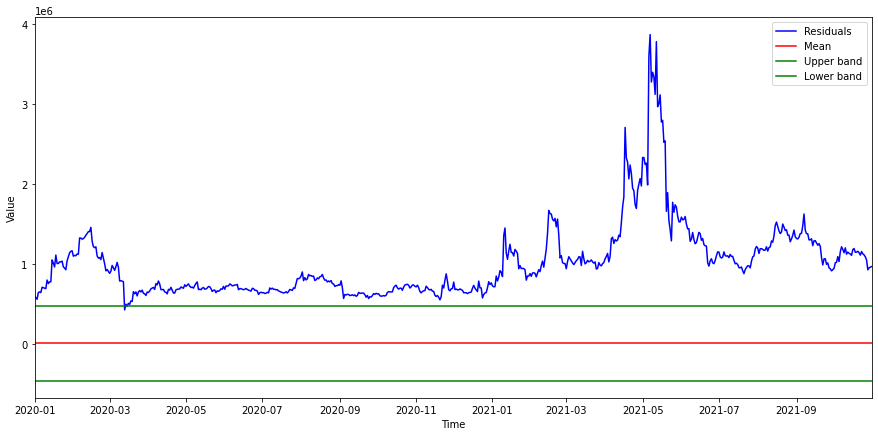

In [13]:
cgp.plot_series([residuals, spread_mean, upper_band, lower_band], colors=['blue', 'red', 'green', 'green'])

In [15]:
############
## TEST 3 ##
############

d_1, d_2 = CGProcessor.id_to_prices(cgp.cg, PORT_IDS[0], start_date, end_date), CGProcessor.id_to_prices(cgp.cg, PORT_IDS[1], start_date, end_date)
s_1, s_2 = pd.Series(d_1), pd.Series(d_2)
s_1.name, s_2.name = PORT_IDS[0], PORT_IDS[1]

# Random two series likely should not be stationary
coint_res = Tests.is_coint(s_1, s_2)
print(coint_res)

t-stat = -2.6042585933814113 The series None is not stationary with confidence level  99%
False


<Figure size 432x288 with 0 Axes>

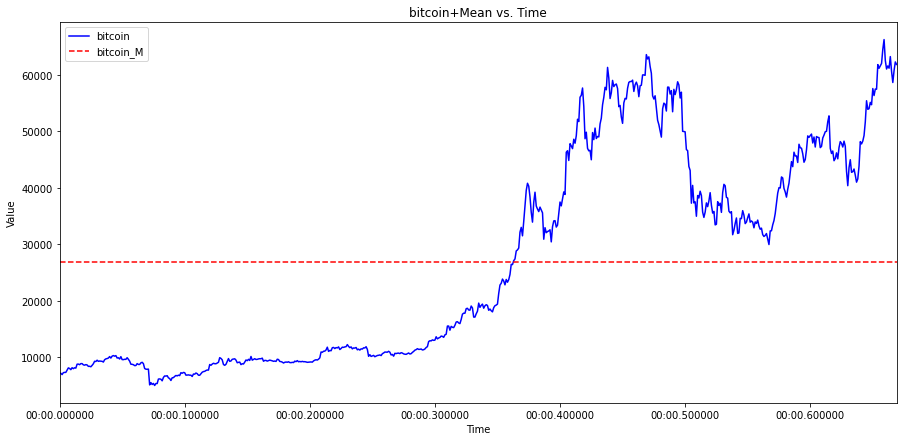

<Figure size 432x288 with 0 Axes>

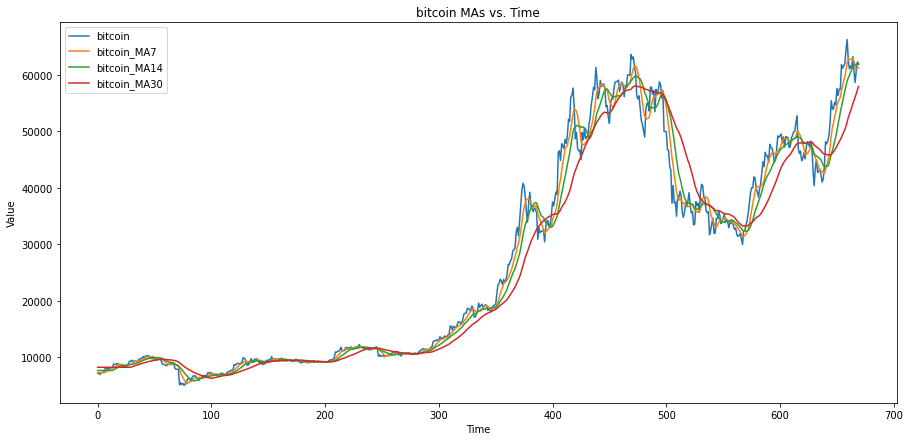

1.6042276429891877


In [16]:
cgp.take_mean(s_1)
df_feats = cgp.series_to_df_feats(s_1, LOOKBACKS, plot=True)

print(Statistics.sharpe_ratio(df_feats[f'{s_1.name}_DR']))
